# tensorFlow物件偵測的 Demo

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
print('成功import12')

成功import12


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
print('env ok')

env ok


## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util
# 內含有將物件偵測結果視覺化的API
from utils import visualization_utils as vis_util
print('ok')

ok


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
# TF已經訓練好的模型名稱
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
# TF已經訓練好的模型檔案(本身是一個tar.gz的壓縮檔)
MODEL_FILE = MODEL_NAME + '.tar.gz'

# 這個TF訓練好模型 所在網站的目錄名稱
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# TF實際用來做物件偵測的模型 
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# 這個模型對應到的種類txt檔，內涵每個種類的索引&名稱
# 之後物件偵測得到的資訊會是索引，所以需要此文件參考名稱
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

# 預設模型種類數量 為90種
NUM_CLASSES = 90
print('Model preparation is ok...')

Model preparation is ok...


## Download Model (如果之前下載過模組，那該這個區塊可以不用再執行一次)

In [5]:
# opener = urllib.request.URLopener()
# # opener.retrieve(下載的檔案來源, 下載的檔案存放的本地位址)
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#     file_name = os.path.basename(file.name)
#     if 'frozen_inference_graph.pb' in file_name:
#         tar_file.extract(file, os.getcwd())
# print('Download Model is ok', os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names,

so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  

Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = (label_map_util.convert_label_map_to_categories(
    label_map, 
    max_num_classes=NUM_CLASSES, 
    use_display_name=True))

category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'name': 'person', 'id': 1}, 2: {'name': 'bicycle', 'id': 2}, 3: {'name': 'car', 'id': 3}, 4: {'name': 'motorcycle', 'id': 4}, 5: {'name': 'airplane', 'id': 5}, 6: {'name': 'bus', 'id': 6}, 7: {'name': 'train', 'id': 7}, 8: {'name': 'truck', 'id': 8}, 9: {'name': 'boat', 'id': 9}, 10: {'name': 'traffic light', 'id': 10}, 11: {'name': 'fire hydrant', 'id': 11}, 13: {'name': 'stop sign', 'id': 13}, 14: {'name': 'parking meter', 'id': 14}, 15: {'name': 'bench', 'id': 15}, 16: {'name': 'bird', 'id': 16}, 17: {'name': 'cat', 'id': 17}, 18: {'name': 'dog', 'id': 18}, 19: {'name': 'horse', 'id': 19}, 20: {'name': 'sheep', 'id': 20}, 21: {'name': 'cow', 'id': 21}, 22: {'name': 'elephant', 'id': 22}, 23: {'name': 'bear', 'id': 23}, 24: {'name': 'zebra', 'id': 24}, 25: {'name': 'giraffe', 'id': 25}, 27: {'name': 'backpack', 'id': 27}, 28: {'name': 'umbrella', 'id': 28}, 31: {'name': 'handbag', 'id': 31}, 32: {'name': 'tie', 'id': 32}, 33: {'name': 'suitcase', 'id': 33}, 34: {'name': 'frisbee

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
import time 

# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

-----------------------------------------------------
-----------------------------------------------------
---------------- test_images/image1.jpg--------------
-----------------------------------------------------
-----------------------------------------------------
========Result 1 對應原始物件索引陣列的字典 ========
key = dog , value = [0 1] 

========Result 2 原始物件的標記位置陣列 ========
[[ 0.03707662  0.02323911  0.86202097  0.3184416 ]
 [ 0.10014138  0.39191613  0.95882225  0.97357213]] 

========Result 3 原始物件的相似分數陣列 ========
[ 0.90206975  0.83960396] 

-----------------------------------------------------
-----------------------------------------------------
---------------- test_images/image2.jpg--------------
-----------------------------------------------------
-----------------------------------------------------
========Result 1 對應原始物件索引陣列的字典 ========
key = person , value = [1 2 4 5] 

key = kite , value = [0 3 6 7] 

========Result 2 原始物件的標記位置陣列 ========
[[ 0.38932127  0.34821382  0.40933746

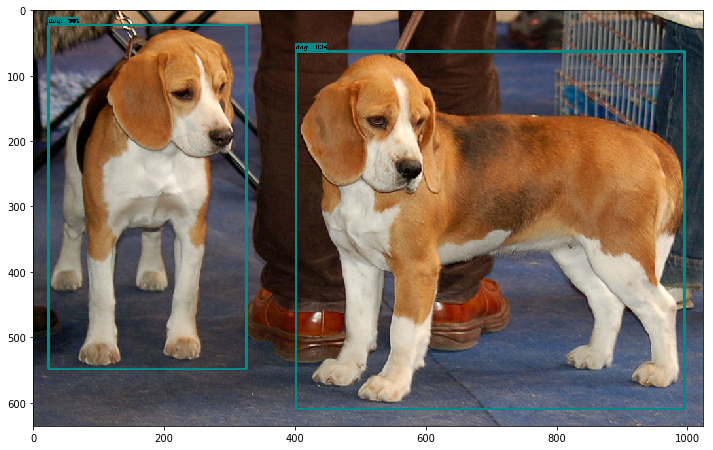

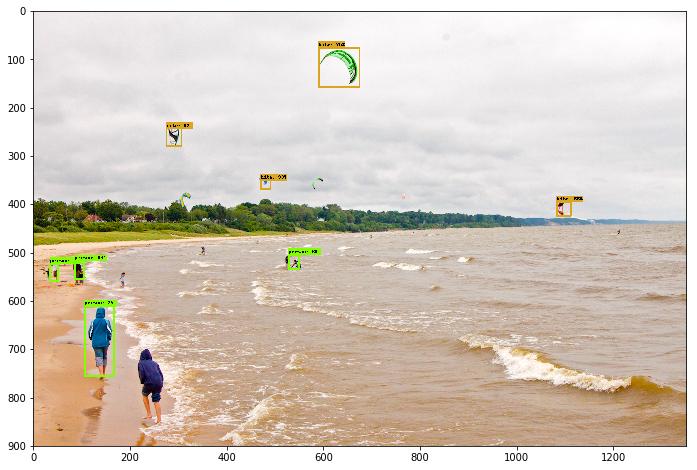

In [27]:
tStart = time.time()

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
#     # 印出每個物件的位置.分數.種類
#       print('boxes[0]:', boxes[0])
#       print('scores[0]:', scores[0])
#       print('classes:', classes)
#       print('\n\n\n')
      for i in range(2):
          print("-----------------------------------------------------")
      print('---------------- %s--------------' % image_path)      
      for i in range(2):
        print("-----------------------------------------------------")
      # 分數高於0.5的才可以視為相符
      obj_length = len([x for x in scores[0] if x > 0.5])
      width, height = image.size
    
      # 第一實驗魔改_Begin 該圖片所有的物件種類   
      all_objs = classes[0]
      ok_objs = all_objs[0:obj_length]
      objs_classes = set(ok_objs)
    
      # Result 1 對應原始物件索引陣列的字典(Key為類別名， Value為對應原始陣列的物件索引陣列)
      img_classes = dict()
      for obj_class in objs_classes:
        img_classes[category_index[obj_class]['name']] = np.nonzero(ok_objs == obj_class)[0]
#         print('種類:', category_index[obj_class]['name'])
#         print(np.nonzero(ok_objs == obj_class)[0], '有', len(np.nonzero(ok_objs == obj_class)[0]),'個') 

      # Result 2 原始物件的標記位置陣列[(x1, y1, x2, y2)]
      img_obj_coordinates = boxes[0][0:obj_length]
        
      # Result 3 原始物件的相似分數陣列
      img_obj_scores = scores[0][0:obj_length]

#------------------------------------------------------------------
#--------------印出第一實驗的結果 Begin--------------
#------------------------------------------------------------------

#       印出Result 1
      print('========Result 1 對應原始物件索引陣列的字典 ========')
      for  key, value in img_classes.items():
        print('key =', key, ', value =', value, '\n')

#       印出Result 2
      print('========Result 2 原始物件的標記位置陣列 ========')
      print(img_obj_coordinates, '\n')

#       印出Result 3 
      print('========Result 3 原始物件的相似分數陣列 ========')
      print(img_obj_scores, '\n')

#------------------------------------------------------------------
#--------------印出第一實驗的結果 End--------------
#------------------------------------------------------------------

#       # 谷歌魔改：嘗試取出 抓到物件的座標---------開頭
#       for obj_inx in range(0, obj_length):
#           obj_category = int(classes[0][obj_inx])
#           print('類別索引:', obj_category)  
#           print('類別名稱:', category_index[obj_category]['name'])
#           print('座標box:', obj_inx, ':', boxes[0][obj_inx])
#           print('相似度:', obj_inx, ':', scores[0][obj_inx])
#           box = boxes[0][obj_inx]
#           # coordinate = [物件的x1座標, 物件的y1座標, 物件的x2座標, 物件的y2座標]
#           coordinate = [box[1]*width, box[0]*height,
#           box[3]*width, box[2]*height]
#           print(coordinate)
# #           plt.figure(figsize=IMAGE_SIZE)
# #           # 印出
# #           plt.imshow(image.crop(coordinate))
#       # 谷歌魔改  ---結尾
      # 第一實驗魔改_End
      
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=4)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
tEnd = time.time()
print('結束:', tEnd - tStart)



# 第一個實驗要輸出的內容的形式

## 每張照片都會有3個陣列。

### Ok 1. 對應原始物件索引陣列的字典   變數名稱 img_classes
(Key為類別名， Value為對應原始陣列的物件索引)

<code>
這邊索引會直接用名稱Person或是Dog這類名稱，而非整數。
雖然聽起來用字串當索引效率變差，但會少掉一層中介方便後續操作。
Dog -> [0 1 3]
Person -> [2 4 5]
以上含義代表在原始物件陣列的索引0 1 3都是狗，
代表原始物件陣列的索引2 4 5都是人。
</code>
### 2. 原始物件的標記位置陣列(x1, y1, x2, y2)  變數名稱 img_obj_coordinates
### 3. 原始物件的相似分數陣列ex: 0.87             變數名稱 img_obj_scores



